# Description:
Given the rough location of an event, download data for this event for stations meeting a certain epicentral distance criteria.

# Setups

In [1]:
from obspy.clients.fdsn import Client
from obspy.core.event import Origin
from obspy.geodetics import gps2dist_azimuth, kilometer2degrees
from obspy.taup import TauPyModel
from obspy.io.sac.sactrace import SACTrace
from obspy import read_inventory, UTCDateTime
from obspy import read

import numpy as np
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib notebook

# ***CHANGE THIS*** - things that need to be manually changed for each event

### Choose:

In [2]:
# web service client:
client = Client("IRIS")

# Earth model:
model = TauPyModel(model='iasp91')

# folder for this event:
directory = '/Users/23brianc/Documents/Internship2020/Events/Canada_38/'

# directory to download raw data:
raw_directory = directory+'raw1/'

# directory to store instrument-corrected data:
corrected_directory = directory+'corrected1/'

%mkdir /Users/23brianc/Documents/Internship2020/Events/Canada_38/
%mkdir /Users/23brianc/Documents/Internship2020/Events/Canada_38/raw1/
%mkdir /Users/23brianc/Documents/Internship2020/Events/Canada_38/corrected1/

mkdir: /Users/23brianc/Documents/Internship2020/Events/Canada_38/: File exists


In [3]:
# pre-filter for removing instrument response:
prefilt = (0.05,0.1,10,20)

def detrend_and_remove_response(stream,window):
    for tr in stream:
        tr.detrend(type='constant')  # de-mean
        tr.detrend(type='linear')
        tr.remove_response(output='VEL',taper = True, taper_fraction = 0.05,pre_filt= window, water_level = 60.0)
    return stream

# Search for stations given an event

In [4]:
# search for stations certain distance away from event
station_search_lower_range=kilometer2degrees(0)  #in km
station_search_upper_range=kilometer2degrees(300)

In [5]:
# event location: latitude and longitude

evla = 49.310 # ***CHANGE THIS***
evlo = -112.780 # ***CHANGE THIS***

# search timeframe
starttime = UTCDateTime("2008-01-02T13:16:33") # ***CHANGE THIS***
endtime = UTCDateTime("2008-01-04T13:16:33") # ***CHANGE THIS***

# station inventory
inventory = client.get_stations(level='response',channel='BH*',starttime=starttime,endtime=endtime,latitude=evla,
                               longitude=evlo, minradius=station_search_lower_range,
                                maxradius=station_search_upper_range) #network = 'XI'
inventory.write(directory+"inventory.xml",format='STATIONXML')
# inventory[x][y] gives you station y in network x

In [6]:
inventory

Inventory created at 2021-08-19T04:06:05.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2008-01-02...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (4):
			CN, TA, US, Y5
		Stations (33):
			CN.WALA (Waterton Lake, AB, CA)
			TA.A11A (Hall Mountain, Copeland, ID, USA)
			TA.A12A (Yaak River Ranch, Troy, MT, USA)
			TA.A13A (Flathead National Forest, Polebridge, MT, USA)
			TA.A14A (Double T Ranch, Babb, MT, USA)
			TA.A15A (Johnson Ranch, Cut Bank, MT, USA)
			TA.A16A (West Butte Ranch, Sweetgrass, MT, USA)
			TA.A17A (Triple J Farms, Joplin, MT, USA)
			TA.A18A (Metzger Ranch, Havre, MT, USA)
			TA.B11A (Sandpoint, ID, USA)
			TA.B12A (Libby, MT, USA)
			TA.B13A (Whitefish, MT, USA)
			TA.B14A (Marquette Ranch, East Glacier, MT, USA)
			TA.B15A (Bradely Ranch, Valier, MT, USA)
			TA.B16A (M & M Farms, Shelby, MT, USA)
			TA.B17A (L&G Farms, Chester, MT, USA)
			TA.B18A (Beardsley 

#### plot a station map if you want to

/Users/23brianc/anaconda3/lib/python3.7/site-packages/obspy/imaging/maps.py:46: UserWarning: basemap/pyproj with proj4 version >= 5 has a bug that results in inverted map axes. Your maps may be wrong. Please use another version of proj4, or use cartopy. See https://github.com/matplotlib/basemap/issues/443
  warnings.warn(msg)


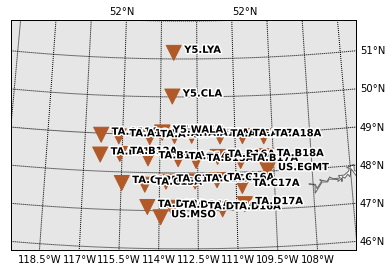

In [7]:
stn_map = inventory.plot(projection="local",show=False)

# Let the computer know the event

In [8]:
event_search_max_radius = kilometer2degrees(200) #in km

In [9]:
catalogue = client.get_events(starttime=starttime,endtime=endtime,latitude=evla,longitude=evlo,
                              maxradius=event_search_max_radius, minmagnitude=1,mindepth=0) # ***CHANGE THIS*** mindepth, minmag
print(catalogue)

1 Event(s) in Catalog:
2008-01-03T13:28:13.570000Z | +49.287, -112.810 | 3.4 ML


#### Get event information

In [10]:
event_info = catalogue.events[0].origins[0]
origin_time = event_info.time
evlo = event_info.longitude
evla = event_info.latitude
evdp = event_info.depth

yr = origin_time.year
jd = origin_time.julday
hr = origin_time.hour
mins = origin_time.minute
sec = origin_time.second
msec = origin_time.microsecond

# convert event depth to km if necessary
if evdp > 1000:
    evdp = evdp / 1000

In [13]:
print(catalogue.events[0])

Event:	2019-12-23T22:34:08.160000Z | +41.522, -110.026 | 3.2 ML

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=11161759")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=41837947")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=197294075")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


In [14]:
%store -r common_stations

origin_to_p_deep = []

for net in inventory[:]:
    for stn in net[:]:
        stla = stn.latitude
        stlo = stn.longitude
        geo = gps2dist_azimuth(stla,stlo,evla,evlo)
        epi_dist = geo[0]/1000   #in km
        baz = geo[1]
        gcarc = kilometer2degrees(epi_dist) # convert arc length to angle
        
        arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])
        P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
        seconds_before_P = P_arrival_time_at_stn - 120
        seconds_after_P = P_arrival_time_at_stn + 1000
        
        for temp in common_stations:
                if temp["stnm"] == (net.code+"."+stn.code):
                    origin_to_p_deep.append(arrival[0].time)
                    

In [15]:
%store origin_to_p_deep

Stored 'origin_to_p_deep' (list)


#### Plot a station-event map if you want to (not working now)

In [16]:
catalogue.plot(fig=stn_map);

<Figure size 432x288 with 0 Axes>

# Loop over each station in each network to request data

In [11]:
for net in inventory[:]:
    for stn in net[:]:
        stla = stn.latitude
        stlo = stn.longitude
        geo = gps2dist_azimuth(stla,stlo,evla,evlo)
        epi_dist = geo[0]/1000   #in km
        baz = geo[1]
        gcarc = kilometer2degrees(epi_dist) # convert arc length to angle
        
        arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])
        P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
        seconds_before_P = P_arrival_time_at_stn - 120
        seconds_after_P = P_arrival_time_at_stn + 1000
        print(P_arrival_time_at_stn)
        
        try:
            stream = client.get_waveforms(net.code,stn.code,'*','BH*',origin_time,seconds_after_P,
                               attach_response=True)
        except:
            print('No Data'+' for station '+net.code+'.'+stn.code+' !!')
            continue

        number_of_traces = len(stream)
        number_of_locs = int(len(stream)/3)
        print('Found '+str(number_of_traces)+' traces for station '+net.code+'.'+stn.code)
        
        # remove mean, linear trend and instrument response
        try:
            corrected_stream = detrend_and_remove_response(stream,prefilt);
        except Exception as e:
            print('Cannot correct for station '+net.code+'.'+stn.code+' !!'+' due to ', e)
            continue
        
        # write raw data
        for tr in stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = raw_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)
        
        # write corrected data
        for tr in corrected_stream:
            loc = tr.stats.location
            chan = tr.stats.channel
            sacnm = corrected_directory+'/'+net.code+'.'+stn.code+'.'+str(loc)+'.'+str(yr)+'-'+str(jd).zfill(3)+'-'+str(hr).zfill(2)+'-'+str(mins).zfill(2)+'-'+str(sec).zfill(2)+'.'+chan+'.SAC'
            sac = SACTrace.from_obspy_trace(tr)
            sac.gcarc = gcarc
            sac.baz = baz
            sac.evlo = evlo
            sac.evla = evla
            sac.stlo = stlo
            sac.stla = stla
            sac.evdp = evdp
            sac.a = P_arrival_time_at_stn
            sac.o = origin_time
            sac.write(sacnm)

2008-01-03T13:28:28.178246Z
No Data for station CN.WALA !!
2008-01-03T13:28:52.284589Z
Found 3 traces for station TA.A11A
2008-01-03T13:28:46.015663Z
Found 3 traces for station TA.A12A
2008-01-03T13:28:34.861076Z
Found 3 traces for station TA.A13A
2008-01-03T13:28:23.493162Z
Found 3 traces for station TA.A14A
2008-01-03T13:28:19.813611Z
Found 3 traces for station TA.A15A
2008-01-03T13:28:30.234951Z
Found 3 traces for station TA.A16A
2008-01-03T13:28:39.515938Z
Found 3 traces for station TA.A17A
2008-01-03T13:28:47.127915Z
Found 3 traces for station TA.A18A
2008-01-03T13:28:54.225624Z
Found 3 traces for station TA.B11A
2008-01-03T13:28:47.495001Z
Found 3 traces for station TA.B12A
2008-01-03T13:28:39.493593Z
Found 3 traces for station TA.B13A
2008-01-03T13:28:32.330621Z
Found 3 traces for station TA.B14A
2008-01-03T13:28:32.568204Z
Found 3 traces for station TA.B15A
2008-01-03T13:28:35.311057Z
Found 3 traces for station TA.B16A
2008-01-03T13:28:42.718507Z
Found 3 traces for station TA.B

In [21]:
type(seconds_before_P)

obspy.core.utcdatetime.UTCDateTime

### Quick preview of downloaded data

In [32]:
raw_st = read(raw_directory+'*')
corrected_st = read(corrected_directory+'*')

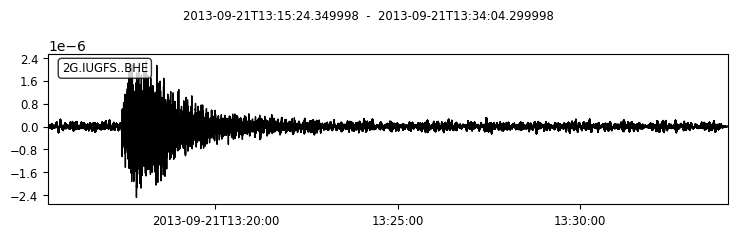

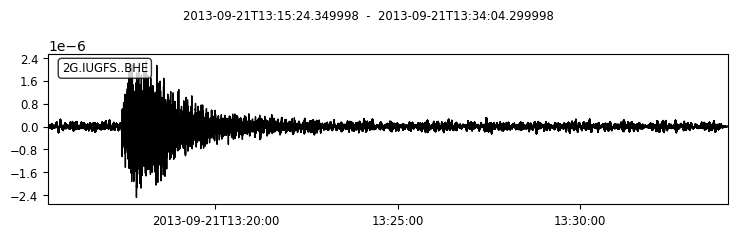

In [33]:
index = 0

raw_st[index].plot();
corrected_st[index].plot();

# Play around with individual case

In [49]:
stn = inventory[6][40]
stla = stn.latitude
stlo = stn.longitude
geo = gps2dist_azimuth(stla,stlo,evla,evlo)
epi_dist = geo[0]/1000. #in km
baz = geo[1]
gcarc = kilometer2degrees(epi_dist) # convert arc length to angle

In [50]:
model = TauPyModel(model='ak135')
arrival = model.get_travel_times(source_depth_in_km=evdp, distance_in_degree=gcarc, phase_list=['P','p'])

In [51]:
P_arrival_time_at_stn = origin_time + arrival[0].time  #Only works when the UTCDateTime is first
seconds_before_P = P_arrival_time_at_stn - 1000
seconds_after_P = P_arrival_time_at_stn + 2000

In [52]:
try:
    data = client.get_waveforms('G','WUS','*','BH*',seconds_before_P,seconds_after_P,
                               attach_response=True)
except:
    print('No Data!')

number_of_traces = len(data)
number_of_locs = int(len(data)/3)
print('Find '+str(number_of_traces)+' traces for station')  

No Data!


NameError: name 'data' is not defined

In [ ]:
data.plot();

In [ ]:
detrend_and_remove_response(data,prefilt);
data.plot();

In [ ]:
inventory[-1][61]